In [ ]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

# MNIST dataset (images and labels)
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor(),download=True)

test_dataset = MNIST(root='data/', train=False,transform=transforms.ToTensor(),download=True)


train_ds, val_ds = random_split(dataset, [50000, 10000])


batch_size = 128

#create train,validation and test loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_dataset, batch_size=256)




In [ ]:
len(train_ds)

50000

In [ ]:
class MnistModel(nn.Module):
    def __init__(self,input_size,num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    """
    the forward function will reshape the input 3D image vectors to 2D Vector
    because the 3D vectors are not supported by torch

    """
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

    def evaluate(self,val_loader):
        outputs = [self.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(outputs)


    def accuracy(self,outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))


    def fit(self,epochs, lr, train_loader, val_loader, opt_func=torch.optim.SGD):
        optimizer = opt_func(self.parameters(), lr)
        history = [] # for recording epoch-wise results

        for epoch in range(epochs):

            # Training Phase
            for batch in train_loader:
                loss = self.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation phase
            result = self.evaluate(val_loader)
            self.epoch_end(epoch, result)
            history.append(result)
            print(len(history))


        return history

In [ ]:
input_size = 28*28
num_classes = 10

model = MnistModel(input_size,num_classes)

In [ ]:
history = model.fit(epochs=60,lr=0.001,train_loader=train_loader,val_loader=val_loader)

Epoch [0], val_loss: 1.9736, val_acc: 0.5943
1
Epoch [1], val_loss: 1.7003, val_acc: 0.7107
2
Epoch [2], val_loss: 1.4971, val_acc: 0.7481
3
Epoch [3], val_loss: 1.3436, val_acc: 0.7696
4
Epoch [4], val_loss: 1.2255, val_acc: 0.7823
5
Epoch [5], val_loss: 1.1329, val_acc: 0.7934
6
Epoch [6], val_loss: 1.0585, val_acc: 0.8020
7
Epoch [7], val_loss: 0.9976, val_acc: 0.8087
8
Epoch [8], val_loss: 0.9470, val_acc: 0.8126
9
Epoch [9], val_loss: 0.9042, val_acc: 0.8185
10
Epoch [10], val_loss: 0.8676, val_acc: 0.8232
11
Epoch [11], val_loss: 0.8359, val_acc: 0.8268
12
Epoch [12], val_loss: 0.8082, val_acc: 0.8299
13
Epoch [13], val_loss: 0.7837, val_acc: 0.8330
14
Epoch [14], val_loss: 0.7619, val_acc: 0.8354
15
Epoch [15], val_loss: 0.7423, val_acc: 0.8377
16
Epoch [16], val_loss: 0.7246, val_acc: 0.8400
17
Epoch [17], val_loss: 0.7086, val_acc: 0.8422
18
Epoch [18], val_loss: 0.6940, val_acc: 0.8451
19
Epoch [19], val_loss: 0.6807, val_acc: 0.8466
20
Epoch [20], val_loss: 0.6683, val_acc: 

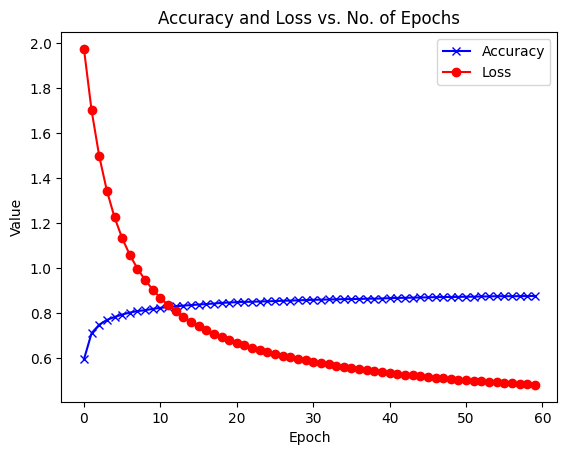

In [ ]:
import matplotlib.pyplot as plt

# Assuming history, history1, and history2 are lists of dictionaries containing 'val_acc' and 'val_loss' values

accuracies = [result['val_acc'] for result in history]
loss = [result['val_loss'] for result in history]


plt.plot(accuracies, '-x', color='blue', label='Accuracy')
plt.plot(loss, '-o', color='red', label='Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss vs. No. of Epochs')
plt.legend()  # Adding legend to differentiate between accuracy and loss

plt.show()


## Testing Phase

This is an image from test data set

Shape: torch.Size([1, 28, 28])
Label: 7


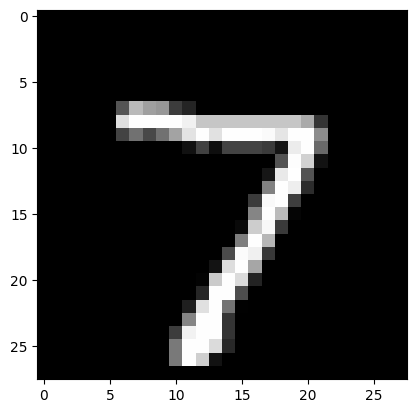

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

torch.max() returns both the maximum values and their corresponding indices along a specified dimension of a tensor.

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb) #give tensor which contain 10 probabiliries for each number
    _, preds = torch.max(yb, dim=1)#choose maximum probability
    return preds[0].item()

Label: 7 , Predicted: 7


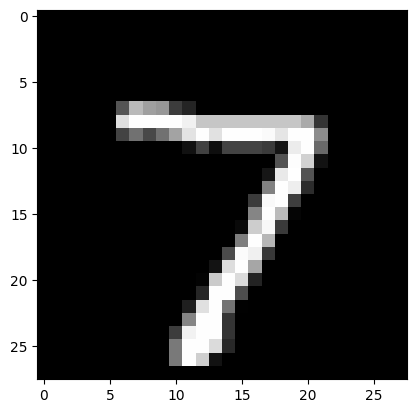

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [ ]:
result = model.evaluate(test_loader)
result

{'val_loss': 0.44423937797546387, 'val_acc': 0.88623046875}

##How to save the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), 'hand_written_digit.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0136, -0.0313, -0.0354,  ...,  0.0171,  0.0085,  0.0037],
                      [-0.0127,  0.0328,  0.0188,  ...,  0.0234,  0.0214, -0.0006],
                      [ 0.0066, -0.0242, -0.0010,  ..., -0.0210, -0.0208, -0.0249],
                      ...,
                      [-0.0096, -0.0020,  0.0119,  ..., -0.0278,  0.0157, -0.0115],
                      [-0.0167, -0.0258,  0.0294,  ..., -0.0177,  0.0125,  0.0028],
                      [ 0.0282, -0.0176, -0.0315,  ...,  0.0083,  0.0264,  0.0336]])),
             ('linear.bias',
              tensor([-0.0669,  0.1598, -0.0166, -0.0359,  0.0537,  0.1251, -0.0330,  0.0861,
                      -0.2198,  0.0005]))])

#### load the saved model

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [ ]:
input_size = 28*28
num_classes = 10


model2 = MnistModel(input_size=input_size,num_classes=num_classes)
model2.load_state_dict(torch.load('hand_written_digit.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
result = model2.evaluate(test_loader)
result

{'val_loss': 0.44423937797546387, 'val_acc': 0.88623046875}